In [1]:
"""
This is a single agent actor-critic implementation.
It is specifically designed to work with the four rooms environment, but it should work with any gym environment.
"""

import sys
import torch  
import gym
# from tqdm import tqdm
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd


/home/douglas/classes/RL/project/CS5180-project/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class ActorCriticSingleAgent(nn.Module):
    """
    A simple, but flexible, implementation of the actor-critic algorithm.
    """
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCriticSingleAgent, self).__init__()

        self.num_actions = num_actions
        # estimate the value function
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        # estimate the policy distribution
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        """
        Do inference to calculate the action probabilities and the state value.
        """
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        # softmax effectively generates a probability for each of our output options
        policy_dist = F.softmax(self.actor_linear2(policy_dist))

        return value, policy_dist

In [4]:
"""
This doesn't quite use entropy correctly and it doesn't bootstrap correctly.
BUT. it is a start.
"""
def a2c(env, hidden_size, learning_rate, num_episodes, num_steps, gamma=0.99, num_classes=11):
    num_inputs = env.observation_space.shape[0] * num_classes
    num_outputs = env.action_space.n
    
    actor_critic = ActorCriticSingleAgent(num_inputs, num_outputs, hidden_size)
    # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    # all episode length
    all_lengths = []
    # average episode length
    average_lengths = []
    # all episode rewards
    all_rewards = []
    
    entropy_term = 0

    for episode in range(num_episodes):
        log_probs = []
        values = []
        rewards = []

        state, _ = env.reset()
        for steps in range(num_steps):
            state_tensor = torch.flatten(F.one_hot(torch.tensor(state, dtype=torch.int64), num_classes=num_classes))
            value, policy_dist = actor_critic.forward(state_tensor.float())
            # drop the tensor dimension and computational graph info
            value = value.detach().numpy()
            dist = policy_dist.detach().numpy() 

            # Sample an action according the probs the network just output.
            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            # Calculate the log probability of the action we've taken
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            # 
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state
            
            if done or steps == num_steps-1:
                state_tensor = torch.flatten(F.one_hot(torch.tensor(new_state, dtype=torch.int64), num_classes=num_classes))
                Qval, _ = actor_critic.forward(state_tensor.float())
                Qval = Qval.detach().numpy()
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 10 == 0:
                    # Where total length is the number of steps taken in the episode and average length is average steps in all episodes seen 
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break
        
        # compute Q values
        # These are the rewards plus discounted state values to calculate the advantage
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + gamma * Qval
            Qvals[t] = Qval
  
        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)
        
        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

    return all_rewards, all_lengths, average_lengths

In [6]:
"""
An OpenAI Gym environment for the Four Rooms domain. 
This is modified with permission from Christian Diamore's work.
"""

import gym
import numpy as np
from gym import spaces
from gym.utils import seeding

rooms = [
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
]


class FourRooms(gym.Env):
    def __init__(self, grid: list = rooms, timeout=459):
        # define the four room as a 2-D array for easy state space reference and
        # visualization 0 represents an empty cell; 1 represents a wall cell

        # NOTE: the origin for a 2-D numpy array is located at top-left
        # while the origin for the FourRooms is at the bottom-left. The following
        # codes performs the re-projection by reversing the rows
        self.grid = np.array(list(reversed(grid)))

        # define the action space
        self.observation_space, self.action_space = (
            spaces.MultiDiscrete(self.grid.shape, dtype=np.int8),
            spaces.Box(low=-1, high=1, shape=(2,), dtype=int),
        )

        # define the start and goal state
        self.agent_state = (0, 0)
        self.start_state = (0, 0)
        self.goal_state = (10, 10)

        self.t = 0
        self.timeout = timeout

    def reset(self):
        """
        Reset the agent's state to the start state [0, 0]
        Return both the start state and reward
        """
        # reset the agent state to be [0, 0]
        self.agent_state, self.t = self.start_state, 0
        return np.array(self.agent_state), {}

    def is_wall(self, state: tuple):
        return (
            not self.observation_space.contains(np.array(state))
            or self.grid[state] == 1
        )

    def step(self, act: tuple):
        """
        :param act:
            a tuple in {[1, 0], [-1, 0], [0, 1], [0, -1]} representing an
            update to the state space

        :returns:
            :next_state: tuple
                x, y integer coordinates of the agent's new state, i.e. (1, 1)
            :reward: int
                1 if the agent reached the goal, else 0
            :done: bool.
                whether the episode is done, either by hitting goal or timeout
                on the episode
        """
        self.t += 1

        # Compute the next state, and only update if we don't hit a wall
        next_state = tuple(np.array(self.agent_state) + np.array(act))
        if not self.is_wall(next_state): self.agent_state = next_state

        # Reward the agent if it hits the goal
        # Done if it was rewarded, or if it times out the episode
        reward = 1.0 if self.agent_state == (10, 10) else 0
        done = reward == 1.0 or (self.t >= self.timeout)

        return np.array(self.agent_state), reward, done, False, {}

    def render(self, mode="human"):
        pass


class FourRoomsController(gym.ActionWrapper):
    """Map from a discrete action space into an actual movement in the grid."""

    def __init__(self, environment: gym.Env, controls: dict[int, tuple]):
        assert all(
            environment.action_space.contains(move)
            for move in controls.values()
        )

        super().__init__(environment)
        self.controls = controls
        self.action_space = spaces.Discrete(len(controls))

    def action(self, action):
        return self.controls[action]

    def reverse_action(self, action):
        return -1 * self.controls[action]


class FourRoomsRandomJitter(gym.ActionWrapper):
    """
    With probability p, the agent takes the correct direction.
    With probability 1 - p, the agent takes one of the two perpendicular actions.

    For example, if the correct action is "LEFT", then
        - With probability 0.8, the agent takes action "LEFT";
        - With probability 0.1, the agent takes action "UP";
        - With probability 0.1, the agent takes action "DOWN".
    """
    def __init__(self, environment: gym.Env, p: float = 0.8):
        super().__init__(environment)
        self.p = p

    @staticmethod
    def perpendicular_action(action):
        return np.random.choice([2, 3] if action in [0, 1] else [0, 1], 1)[0]

    def action(self, action):
        return (
            action
            if np.random.uniform() < self.p else
            self.perpendicular_action(action)
        )

    def reverse_action(self, action):
        pass

controls={
    0: (-1, 0),  # 'LEFT'
    1: (1, 0),  # 'RIGHT'
    2: (0, -1),  # 'DOWN'
    3: (0, 1),  # 'UP'
}

timeout = 10_000
four_rooms_env_no_jitter = FourRoomsController(FourRooms(rooms, timeout=timeout), controls=controls)

four_rooms_env_jitter = FourRoomsRandomJitter(
    FourRoomsController(FourRooms(rooms, timeout=timeout), controls=controls), p=0.8
)


/home/douglas/classes/RL/project/CS5180-project/venv/lib/python3.10/site-packages/gym/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


In [5]:
hidden_size = 64
learning_rate = 3e-4

# Constants
gamma = 0.99
num_steps = timeout
max_episodes = 5000
all_rewards, all_lengths, average_lengths = a2c(four_rooms_env_no_jitter, hidden_size, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)

/tmp/ipykernel_3580/1729106046.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  policy_dist = F.softmax(self.actor_linear2(policy_dist))


episode: 0, reward: 1.0, total length: 743, average length: 743.0 


/tmp/ipykernel_3580/1218464196.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  values = torch.FloatTensor(values)


episode: 10, reward: 1.0, total length: 1375, average length: 2230.0 
episode: 20, reward: 1.0, total length: 1330, average length: 1706.6 
episode: 30, reward: 1.0, total length: 397, average length: 1077.8 
episode: 40, reward: 1.0, total length: 599, average length: 1545.2 
episode: 50, reward: 1.0, total length: 1656, average length: 1894.4 
episode: 60, reward: 1.0, total length: 411, average length: 1380.6 
episode: 70, reward: 1.0, total length: 921, average length: 694.9 
episode: 80, reward: 1.0, total length: 427, average length: 663.3 
episode: 90, reward: 1.0, total length: 263, average length: 979.5 
episode: 100, reward: 1.0, total length: 559, average length: 831.2 
episode: 110, reward: 1.0, total length: 235, average length: 510.6 
episode: 120, reward: 1.0, total length: 364, average length: 388.7 
episode: 130, reward: 1.0, total length: 409, average length: 450.0 
episode: 140, reward: 1.0, total length: 532, average length: 585.5 
episode: 150, reward: 1.0, total l

In [6]:
all_rewards, all_lengths, average_lengths = a2c(four_rooms_env_jitter, hidden_size, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)

/tmp/ipykernel_3580/1729106046.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  policy_dist = F.softmax(self.actor_linear2(policy_dist))


episode: 0, reward: 1.0, total length: 115, average length: 115.0 
episode: 10, reward: 1.0, total length: 416, average length: 1323.7 
episode: 20, reward: 1.0, total length: 925, average length: 1185.9 
episode: 30, reward: 1.0, total length: 4213, average length: 1589.7 
episode: 40, reward: 1.0, total length: 3372, average length: 1795.2 
episode: 50, reward: 1.0, total length: 1529, average length: 880.9 
episode: 60, reward: 1.0, total length: 238, average length: 797.0 
episode: 70, reward: 1.0, total length: 566, average length: 667.8 
episode: 80, reward: 1.0, total length: 183, average length: 979.0 
episode: 90, reward: 1.0, total length: 957, average length: 829.9 
episode: 100, reward: 1.0, total length: 1010, average length: 1016.8 
episode: 110, reward: 1.0, total length: 209, average length: 1086.4 
episode: 120, reward: 1.0, total length: 2063, average length: 1154.5 
episode: 130, reward: 1.0, total length: 525, average length: 763.0 
episode: 140, reward: 1.0, total 

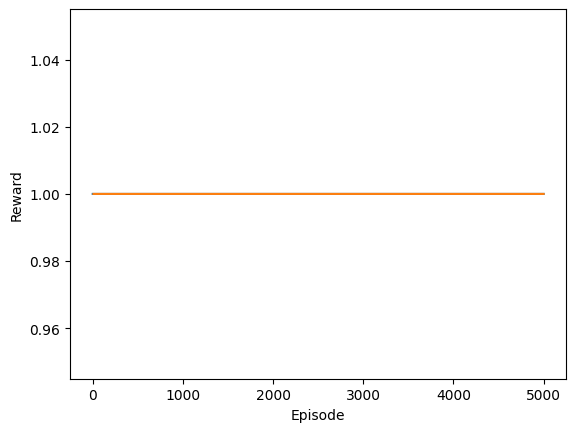

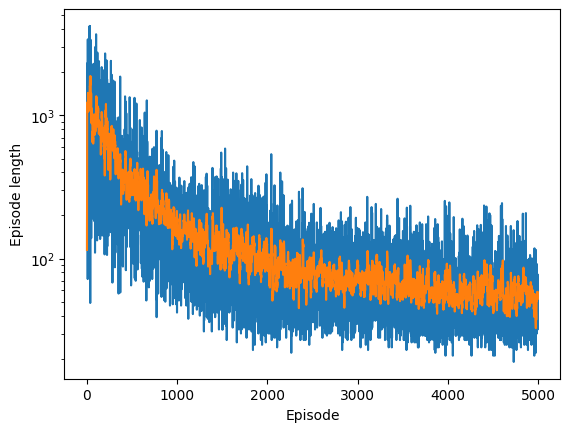

'\nTHESE RESULTS WERE WITH A2C reward of 1 on episode completion only\n'

In [7]:
# Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.plot(all_lengths)
plt.plot(average_lengths)
plt.xlabel('Episode')
plt.ylabel('Episode length')
# modify the y axis to be on a log scale
plt.yscale('log')
plt.show()
"""
THESE RESULTS WERE WITH A2C reward of 1 on episode completion only
"""

In [8]:
"""
These results are generated with a2c reward of 1 on episode completion and -0.5 on every step
"""

all_rewards, all_lengths, average_lengths = a2c(four_rooms_env_jitter, hidden_size, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)

/tmp/ipykernel_3580/1729106046.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  policy_dist = F.softmax(self.actor_linear2(policy_dist))


episode: 0, reward: 1.0, total length: 9484, average length: 9484.0 
episode: 10, reward: 1.0, total length: 2044, average length: 1582.0 
episode: 20, reward: 1.0, total length: 3573, average length: 1539.7 
episode: 30, reward: 1.0, total length: 187, average length: 1182.1 
episode: 40, reward: 1.0, total length: 1545, average length: 1477.8 
episode: 50, reward: 1.0, total length: 1200, average length: 1375.6 
episode: 60, reward: 1.0, total length: 1098, average length: 1590.8 
episode: 70, reward: 1.0, total length: 817, average length: 715.2 
episode: 80, reward: 1.0, total length: 334, average length: 1815.8 
episode: 90, reward: 1.0, total length: 781, average length: 1545.6 
episode: 100, reward: 1.0, total length: 2008, average length: 1286.6 
episode: 110, reward: 1.0, total length: 3526, average length: 1145.8 
episode: 120, reward: 1.0, total length: 2448, average length: 1193.0 
episode: 130, reward: 1.0, total length: 303, average length: 894.7 
episode: 140, reward: 1.

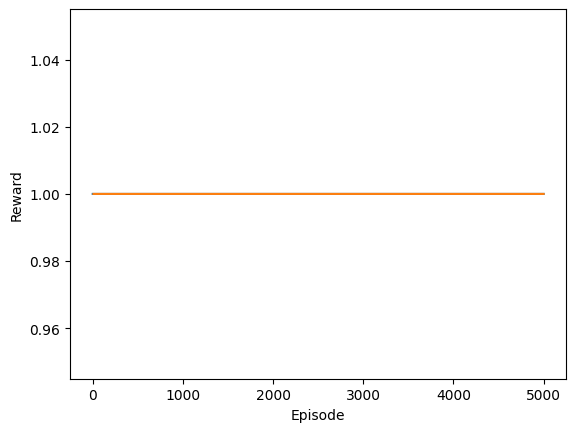

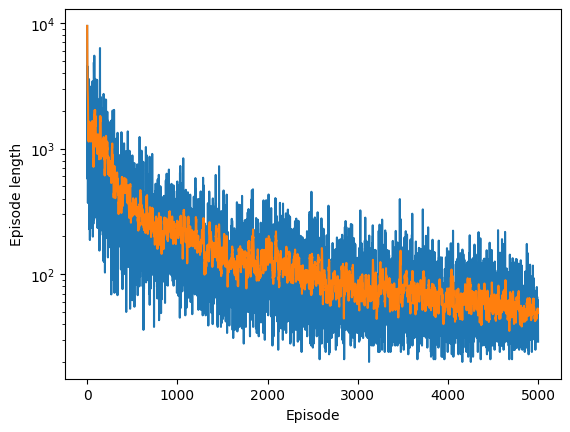

In [9]:
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.plot(all_lengths)
plt.plot(average_lengths)
plt.xlabel('Episode')
plt.ylabel('Episode length')
# modify the y axis to be on a log scale
plt.yscale('log')
plt.show()

In [2]:
class ActorCriticSingleAgent(nn.Module):
    """
    A simple, but flexible, implementation of the actor-critic algorithm.
    """
    def __init__(self, num_inputs, num_actions, hidden_size, lr=3e-4):
        super(ActorCriticSingleAgent, self).__init__()

        self.num_actions = num_actions
        # estimate the value function
        self.critic1 = nn.Linear(num_inputs, hidden_size)
        self.critic2 = nn.Linear(hidden_size, 1)

        # estimate the policy distribution
        self.actor1 = nn.Linear(num_inputs, hidden_size)
        self.actor2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        """
        Do inference to calculate the action probabilities and the state value.
        """
        critic_out = F.relu(self.critic1(state))
        critic_out = self.critic2(critic_out)
        
        actor_out = F.relu(self.actor1(state))
        # softmax effectively generates a probability for each of our output options
        actor_out = F.softmax(self.actor2(actor_out), dim=0)

        return critic_out, actor_out

In [10]:
class A2C:
    def __init__(self, env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma) -> None:
        self.env = env
        self.obs_size = obs_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_episodes = num_episodes
        self.num_steps = num_steps
        self.gamma = gamma

        self.model = ActorCriticSingleAgent(self.obs_size * self.env.observation_space.shape[0], self.output_size, self.hidden_size, self.learning_rate)
    
    def _get_action(self, actor_act_pred):
        # Sample an action according the probs the network just output.
        action = np.random.choice(self.output_size, p=np.squeeze(actor_act_pred))
        return action

    def _obs_to_tensor(self, obs):
        state_tensor = torch.flatten(F.one_hot(torch.tensor(obs, dtype=torch.int64), num_classes=self.obs_size))
        return state_tensor

    def train(self):
        # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
        ac_optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # all episode length
        all_lengths = []
        # average episode length
        average_lengths = []
        all_entropies = []
        all_losses = []
        
        entropy_term = 0

        for episode in range(self.num_episodes):
            log_probs = []
            critic_td_errors = []
            rewards = []

            state, _ = self.env.reset()
            # enable n step actor critic. 
            for steps in range(self.num_steps):
                state_tensor = self._obs_to_tensor(state)
                critic_td_error, actor_act_pred = self.model.forward(state_tensor.float())
                # drop the tensor dimension and computational graph info
                critic_td_error = critic_td_error.detach().numpy()
                detached_act_pred = actor_act_pred.detach().numpy()
                action = self._get_action(detached_act_pred)

                # Calculate the log probability of the action we've taken
                log_prob = torch.log(actor_act_pred.squeeze(0)[action])

                # Calculate the entropy/ uncertainty of the policy term. This is used to encourage exploration
                entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))
                new_state, reward, done, _, _ = self.env.step(action)

                rewards.append(reward)
                critic_td_errors.append(critic_td_error)
                log_probs.append(log_prob)
                entropy_term += entropy
                state = new_state
                
                if done or steps == self.num_steps - 1:
                    state_tensor = self._obs_to_tensor(state)
                    Qval, _ = self.model.forward(state_tensor.float())
                    Qval = Qval.detach().numpy()
                    all_lengths.append(steps)
                    average_lengths.append(np.mean(all_lengths[-10:]))
                    if episode % 30 == 0:
                        # Where total length is the number of steps taken in the episode and average length is average steps in all episodes seen 
                        sys.stdout.write("episode: {}, total length: {}, average length of prev 10: {} \n".format(episode, steps, average_lengths[-1]))
                    break
            
            # compute Q values
            # These are the rewards plus discounted state values to calculate the advantage
            Qvals = np.zeros_like(critic_td_errors)
            for t in reversed(range(len(rewards))):
                Qval = rewards[t] + self.gamma * Qval
                Qvals[t] = Qval
    
            # update actor critic
            critic_td_errors = torch.FloatTensor(np.array(critic_td_errors))
            Qvals = torch.FloatTensor(Qvals)
            log_probs = torch.stack(log_probs)
            
            advantage = Qvals - critic_td_errors
            actor_loss = (-log_probs * advantage).mean()
            critic_loss = 0.5 * advantage.pow(2).mean()
            ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

            ac_optimizer.zero_grad()
            ac_loss.backward()
            ac_optimizer.step()
            all_entropies.append(entropy_term)
            all_losses.append(ac_loss.detach().numpy())
        return all_lengths, average_lengths, all_entropies, all_losses

In [4]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [11]:
"""
These results are generated with a2c reward of 1 on episode completion and -0.5 on every step
"""
hidden_size = 64
learning_rate = 3e-4

# Constants
gamma = 0.99
timeout = 10_000
num_steps = timeout
max_episodes = 5000
state_height = 11

# 22 inputs. 11 for the current state and 11 for the next state. To one hot encode our integer values.
output_size = four_rooms_env_no_jitter.action_space.n
many_run_lengths, many_run_average_lengths, many_run_entropies, many_run_losses = [], [], [], []

for i in range(5):
    agent = A2C(four_rooms_env_no_jitter, state_height, hidden_size, output_size, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)
    all_lengths, average_lengths, all_entropies, all_losses = agent.train()

    many_run_average_lengths.append(average_lengths)

    rolling_avg_entropies = pd.Series(all_entropies).rolling(10).mean()
    many_run_entropies.append(rolling_avg_entropies)
    
    rolling_avg_losses = pd.Series(all_losses).rolling(10).mean()
    many_run_losses.append(rolling_avg_losses)

episode: 0, total length: 442, average length of prev 10: 442.0 
episode: 30, total length: 495, average length of prev 10: 485.7 
episode: 60, total length: 324, average length of prev 10: 372.0 
episode: 90, total length: 374, average length of prev 10: 352.6 
episode: 120, total length: 398, average length of prev 10: 352.0 
episode: 150, total length: 117, average length of prev 10: 341.3 
episode: 180, total length: 636, average length of prev 10: 265.2 
episode: 210, total length: 274, average length of prev 10: 284.2 
episode: 240, total length: 84, average length of prev 10: 243.3 
episode: 270, total length: 190, average length of prev 10: 289.4 
episode: 300, total length: 412, average length of prev 10: 179.2 
episode: 330, total length: 233, average length of prev 10: 229.4 
episode: 360, total length: 211, average length of prev 10: 197.6 
episode: 390, total length: 141, average length of prev 10: 190.9 
episode: 420, total length: 138, average length of prev 10: 166.4 
e

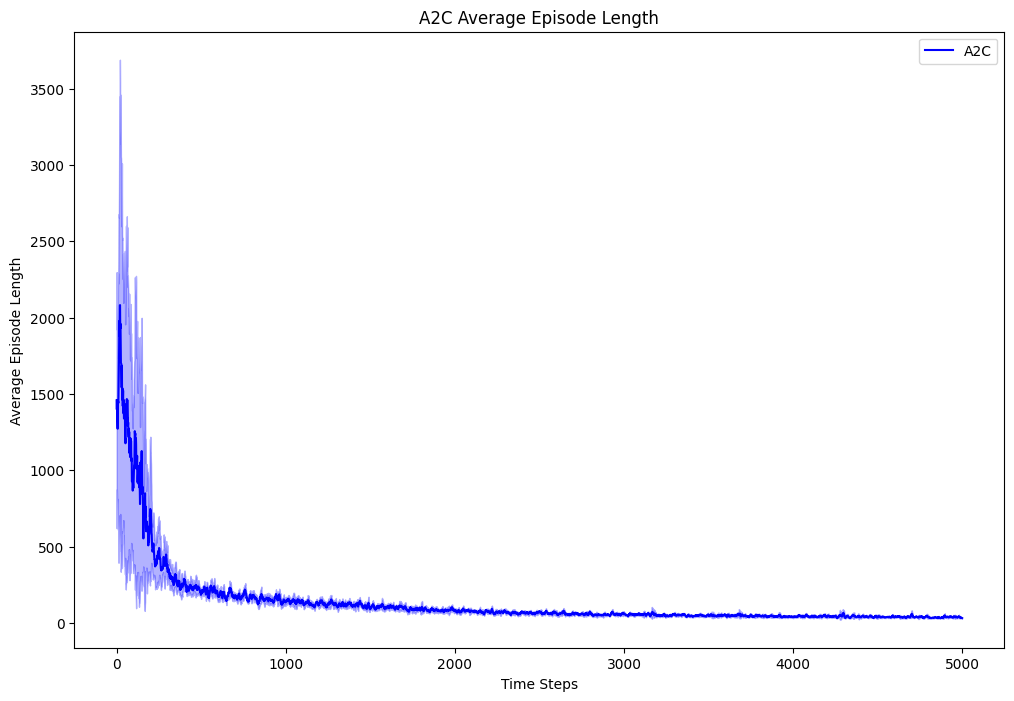

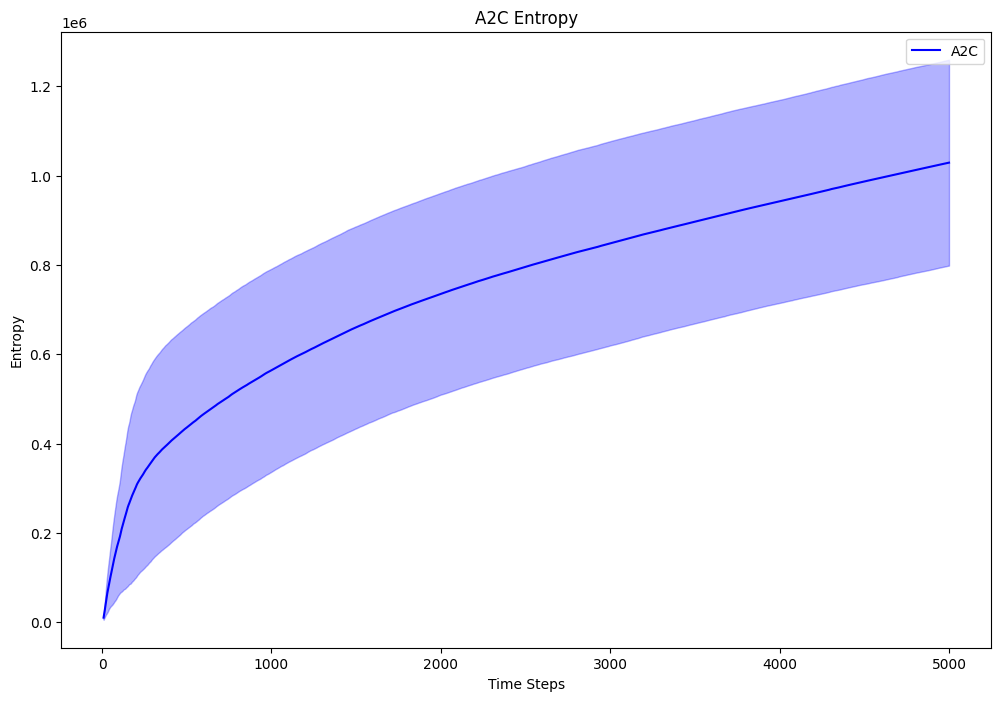

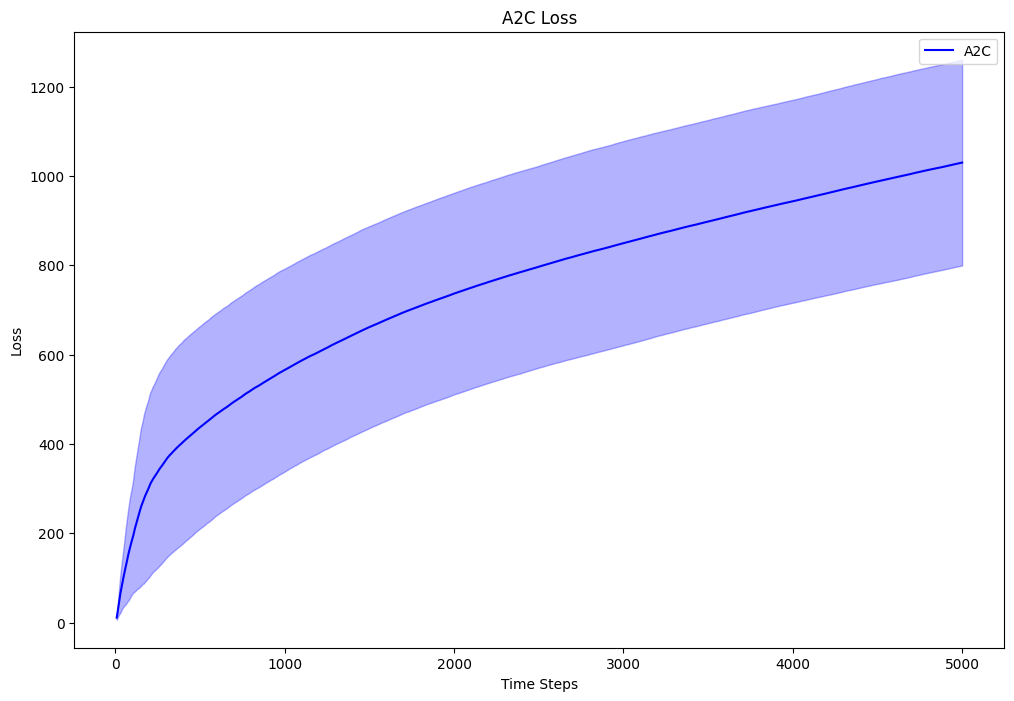

In [16]:
# plot_curves(np.array(many_run_lengths), ["A2C"], ["blue"], "Episode Length", "A2C Episode Length")
plot_curves([np.array(many_run_average_lengths)], ["A2C"], ["blue"], "Average Episode Length", "A2C Average Episode Length")
plot_curves([np.array(many_run_entropies)], ["A2C"], ["blue"], "Entropy", "A2C Entropy")
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Loss", "A2C Loss")